# **--- CNN MODEL ---** #

## **I. Libraries import** ##


In [ ]:
import os
from pathlib import Path
import shutil
import zipfile
import requests
from tqdm import tqdm
import mlflow

# Torch ------------------
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models,datasets
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

# Visualization ---------
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image

from dotenv import load_dotenv

load_dotenv()


We select the appropriate torch device

In [42]:
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple M1/M2/M3
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using mps device


## **II. Images import** ##


### II.1. Extract images from Dataset and dataset refactoring

- function to clean data
- function to reorganize directories (eg: data/train instead of data/train/train)

In [43]:
def reorganize_dataset_dir(dest_data_dir:str)->list:
    '''
        Réorganise le dataset :
          - normalisation et renommage des noms des classes
          - suppression du doublonnage des répertoires
        Input
        - dest_data_dir : le répertoire destination contenant l'extraction du zip du dataset
        Output
        - renvoie les liste des labels du dataset sous sa forme normalisée
    '''
    labels = set()
    for split in ['train','test']:
        # on parcourt le dataset avec le pb data/train/train ou data/test/test
        data_root_path = Path(f'{dest_data_dir}/{split}/{split}')
        if data_root_path.exists() and data_root_path.is_dir():
            for dir_label in data_root_path.iterdir():
                # normalisation des noms de répertoire qui seront les noms des classes
                print(f"dir_label={dir_label}")
                new_label = dir_label.name.replace('Grape ','') \
                    .replace(' leaf','') \
                    .replace('_leaf','') \
                    .replace(' disease','') \
                    .replace(' ','_') \
                    .lower()
                labels.add(new_label)

                # on renomme les répertoires qui sont les noms des classes
                new_dir_label = dir_label.parent / new_label
                if not new_dir_label.exists():
                    try:
                        shutil.move(str(dir_label), str(new_dir_label))
                    except Exception as e:
                        print(f'Erreur renaming {dir_label} to {new_dir_label}')
                else:
                    print(f'{new_dir_label} already exists, ignored...')
            
            # on enlève la redondance split/split des répertoires
            print(f'Remove directory redundancy...')
            try:
                tmp_dir = f'{dest_data_dir}/{split}__'
                print(f'move from {data_root_path} to {tmp_dir}')
                shutil.move(str(data_root_path), tmp_dir) # on renomme en data/train/train__
                print(f'delete {str(data_root_path.parent)}')
                shutil.rmtree(str(data_root_path.parent)) # on supprime data/train
                print(f'move from {tmp_dir} to {dest_data_dir}/{split}')
                shutil.move(tmp_dir, f'{dest_data_dir}/{split}') # on renomme le data/train_ en data/train
            except Exception as e:
                print(f'Erreur moving {data_root_path} to {dest_data_dir} : {e}')
    return list(labels)

def clean_datadir(data_dir:str)->None:
    '''
        Supprime les répertoire train et test d'un répertoire de dataset
    '''
    dir_to_delete = [ f'{data_dir}/train', f'{data_dir}/test', f'{data_dir}/train__', f'{data_dir}/test__' ]
    for d in dir_to_delete:
        try:
            shutil.rmtree(d)
        except Exception as e:
            print(f'Erreur impossible to remove {d}')


- clean data if necessary

In [44]:
data_dir = '../data'
clean_datadir(data_dir)

Erreur impossible to remove ../data/train__
Erreur impossible to remove ../data/test__


- If not already downloaded, get dataset ZIP file from Kaggle...

In [48]:
# Possible to download manually the Kaggle dataset with curl
#
# curl -L -o ~/Downloads/grapes-leafs-disease-7-classes-plantcity-2025.zip\
#  https://www.kaggle.com/api/v1/datasets/download/codewithsk/grapes-leafs-disease-7-classes-plantcity-2025
#
url = "https://www.kaggle.com/api/v1/datasets/download/codewithsk/grapes-leafs-disease-7-classes-plantcity-2025"

data_zip_path = f'{data_dir}/grapes-leafs-disease-7-classes-plantcity-2025.zip'
#data_zip = f"{data_dir}/dataset_zip_test.zip" # pour tests et DEBUG

# Check if file already exists
if os.path.exists(data_zip_path):
    print(f"File already exists: {data_zip_path}")
    print("Skipping download.")
else:
    print(f"Downloading dataset to {data_zip_path}...")
    
    # Download with progress bar
    response = requests.get(url, stream=True, allow_redirects=True)
    response.raise_for_status()
    
    # Get total file size
    total_size = int(response.headers.get('content-length', 0))
    
    # Download with progress bar
    with open(data_zip_path, 'wb') as file, tqdm(
        desc=data_zip_path,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            size = file.write(chunk)
            bar.update(size)
    
    print(f"Download complete: {data_zip_path}")

File already exists: ../data/grapes-leafs-disease-7-classes-plantcity-2025.zip
Skipping download.


In [47]:
# on vérifier si le zip a déjà été dézippé
if not os.path.exists(f'{data_dir}/train/train') or not os.path.exists(f'{data_dir}/test/test'):
    # s'il reste des choses on supprime tout
    clean_datadir(data_dir)

    # extraction du zip
    print(f'Extract {data_zip_path} ...')
    with zipfile.ZipFile(data_zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    
    # réorganisation du dataset
    labels = reorganize_dataset_dir(data_dir)
    print(labels)
else:
    print(f'{data_zip_path} already extracted, ignored...')


Erreur impossible to remove ../data/train
Erreur impossible to remove ../data/test
Erreur impossible to remove ../data/train__
Erreur impossible to remove ../data/test__
Extract ../data/grapes-leafs-disease-7-classes-plantcity-2025.zip ...
dir_label=../data/train/train/Grape shot hole leaf disease
dir_label=../data/train/train/Grape Downy mildew leaf
dir_label=../data/train/train/Grape Normal_leaf
dir_label=../data/train/train/Grape Brown spot leaf
dir_label=../data/train/train/Grape Anthracnose leaf
dir_label=../data/train/train/Grape Mites_leaf disease
dir_label=../data/train/train/Grape Powdery_mildew leaf
Remove directory redundancy...
move from ../data/train/train to ../data/train__
delete ../data/train
move from ../data/train__ to ../data/train
dir_label=../data/test/test/Grape shot hole leaf disease
dir_label=../data/test/test/Grape Downy mildew leaf
dir_label=../data/test/test/Grape Normal_leaf
dir_label=../data/test/test/Grape Brown spot leaf
dir_label=../data/test/test/Grape 

### II.2. Image viewing

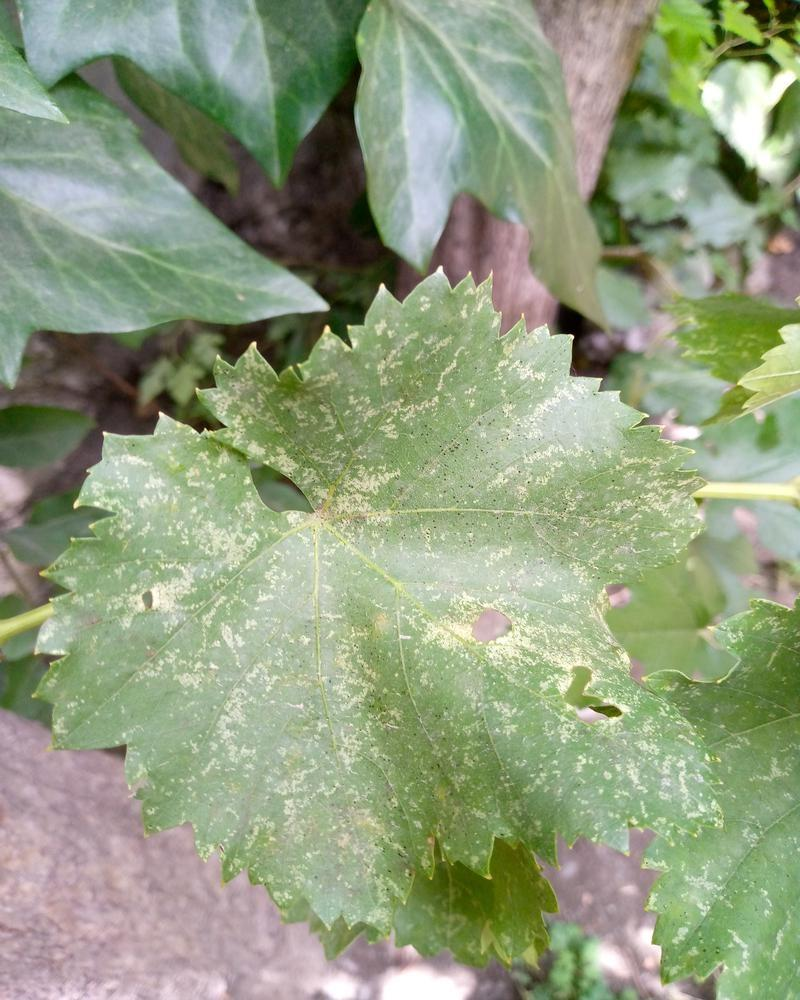

In [13]:
img = Image.open(f"{data_dir}/train/anthracnose/1.jpg")
#img.show()
display(img)

## **III. Images processing** ##


### Pipeline for data transformation ###


The dataset already contains pictures that have been flipped horizontaly, verticaly and randomly rotated. We need to resize the pictures to the size required by the Resnet Model (224,224).

In [45]:
# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionnement à 224x224
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),          # Conversion en tenseur
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # Normalisation avec les valeurs du modèle pré-entraîné Resnet
])

### Load dataset ###


Our dataset is already divided into a train and a test set. We are going to extract 20% of the training set to create the validation set.

In [49]:
# Create the path to the training dataset
data_root = Path(f"{data_dir}/train")

# Load dataset with ImageFolder
dataset = ImageFolder(root=data_root, transform=transform)

# Get class names
class_names = dataset.classes

# Define the set size
train_size = int(0.8 * len(dataset))
val_size = len(dataset)-train_size

# We split our initial train dataset into the final train dataset (80%) and the validation dataset (20%)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [16]:
class_names

['anthracnose',
 'brown_spot',
 'downy_mildew',
 'mites',
 'normal',
 'powdery_mildew',
 'shot_hole']

In [17]:
nb_classes = len(dataset.classes)
nb_classes

7

In [50]:
print(f"- Train dataset size : {train_size} ({train_size/(train_size+val_size)*100:.1f}%)")
print(f"- Validation dataset size :  {val_size} ({val_size/(train_size+val_size)*100:.1f}%)")

- Train dataset size : 5044 (80.0%)
- Validation dataset size :  1261 (20.0%)


In [51]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

###---------------------------------
Si on a le temps :  on peut faire une classe maladie avec toutes les maladies regroupées pour faire un test sain/malade (dans ce cas là on pourra faire une classe personnalisée avec Pytorch dataset et créer le dataset en utilisant cette classe)
---------------------------------------###

Visualisation of a batch

Label : anthracnose


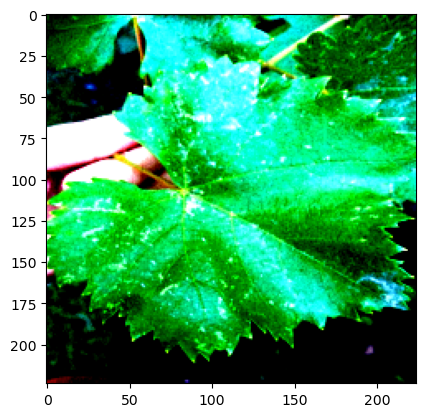

Label : normal


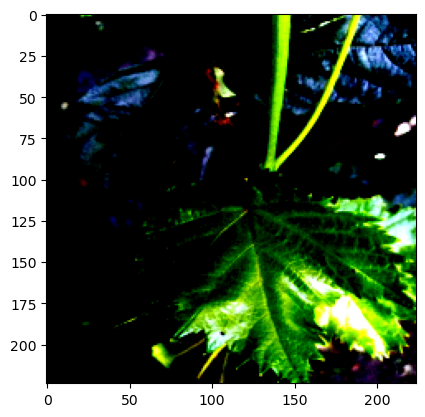

Label : anthracnose


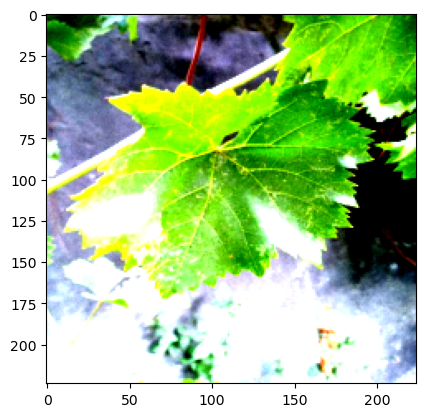

Label : mites


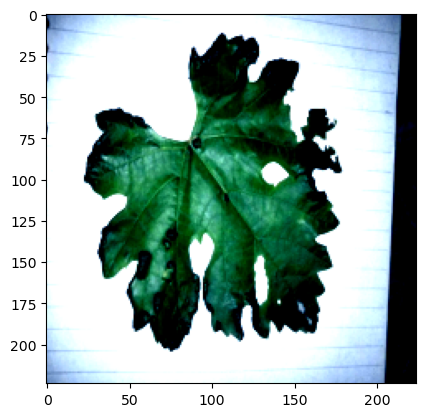

Label : normal


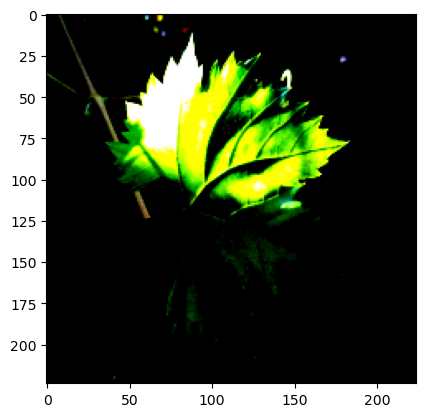

Label : powdery_mildew


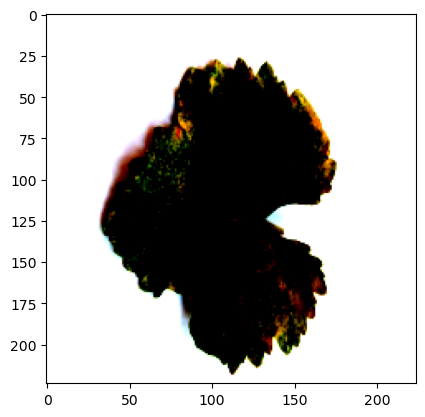

Label : anthracnose


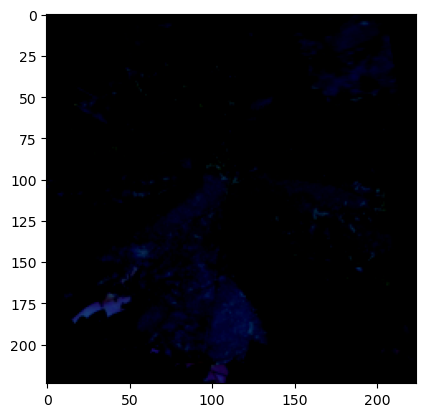

Label : powdery_mildew


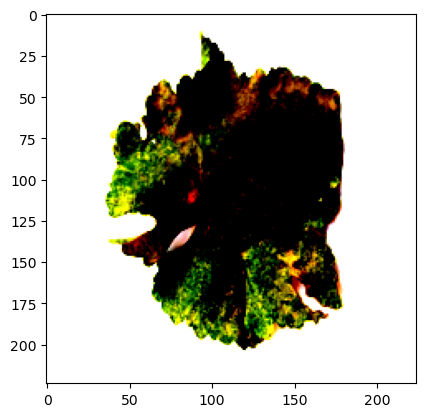

Label : shot_hole


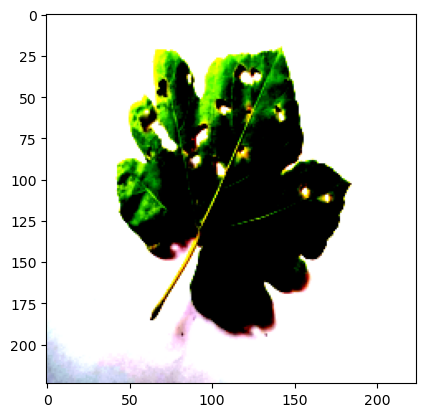

Label : anthracnose


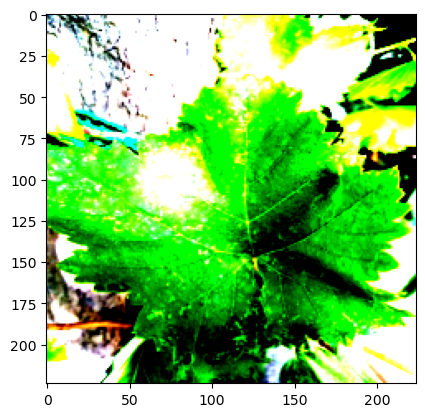

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

imgs, labels = next(iter(train_loader))
for i, (img, label) in enumerate(zip(imgs, labels)):
  true_label_name = class_names[label]
  print("Label :", true_label_name)
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.show()
  if i==9: break

## **Transfert learning (Resnet18)** ##

### Preparing the MLFlow tracking ###

In [ ]:
# Set tracking URI to your Hugging Face application
MLFLOW_URI=os.getenv('MLFLOW_URI',"https://gviel-mlflow37.hf.space/")
mlflow.set_tracking_uri(os.environ["MLFLOW_URI"])

# Set experiment's info
EXPERIMENT_NAME= os.getenv('EXPERIMENT_NAME',"Vitiscan_CNN_MLFlow")
mlflow.set_experiment(EXPERIMENT_NAME)

# Get our experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

### Importing a pre-trained model

In [54]:
#model = models.resnet18(pretrained=True) # pour version <0.13.0
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # pour version >=0.13.0
model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")
print(device)

Model device: mps:0
mps


In [55]:
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### Replace classification layer to adapt the model to our features ###

In [56]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)


### Freeze the feature extraction layers ###

In [57]:
# We freeze all the convolutional layers
for param in model.parameters():
    param.requires_grad = False

# We unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True



In [58]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

- **we can notice that we can train only 3,591 params instead of 11,689,512 initially**

### Adapting the model to the dataset ###

In [59]:
train_dataset.dataset.classes

['anthracnose',
 'brown_spot',
 'downy_mildew',
 'mites',
 'normal',
 'powdery_mildew',
 'shot_hole']

### Defining the cost function and optimizer ###

In [60]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

learning_rate=0.0005
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

### Train the model ###

We check an output on the fist batch

In [61]:
# Model outputs
image, label = next(iter(train_loader))
image=image.to(device)
model=model.to(device)
logit= model(image) # Resnet18 output
logit
# Attention il faut que l'image et le model aient le même device

tensor([[ 0.8493,  0.8965,  0.1378, -1.2056, -0.1904,  0.8423,  0.9268],
        [ 1.3500,  0.4485, -0.3506, -1.4719,  0.2323,  0.2083,  0.9898],
        [ 1.4938,  0.4999,  0.0787, -0.9409, -1.0008, -0.5946,  1.1469],
        [ 1.6896,  0.0652,  0.3081, -0.9002, -0.6361,  0.6512,  0.4273],
        [ 0.7099, -0.5761, -0.3251, -0.7847, -0.8552, -0.2485,  0.2251],
        [ 0.9939,  0.1233,  0.1882, -0.5391, -0.4181, -0.1722,  1.5623],
        [ 1.9245, -0.1600, -0.0440, -1.2381, -0.4850, -0.0473,  1.6004],
        [ 0.9821,  0.1058, -0.3265, -0.7672, -1.0264, -0.2412,  1.0811],
        [ 1.2507, -0.4573,  0.0486, -0.8742, -0.3288, -0.1486,  0.9464],
        [ 1.6961,  0.0864, -0.2739, -0.7066, -0.7270,  0.4443,  1.4257],
        [ 1.1358, -0.6862, -0.4881, -1.0015, -1.4695, -0.0735,  1.5451],
        [ 1.5779,  0.0965,  0.3799, -1.1015, -0.1092, -0.0172,  0.8655],
        [ 0.4397, -0.4396,  0.9764, -1.1596, -0.2311, -0.0471,  1.2650],
        [ 1.1625, -0.0792, -0.2095, -0.9187, -0.775

In [ ]:
# # Training function for a PyTorch model
# def train(model, train_loader, val_loader, criterion, optimizer, epochs=1):
    
#     #  We start a MLFlow run
#     with mlflow.start_run(experiment_id = experiment.experiment_id):

#         # Logging Pytorch parameters into MLFlow 
#         params={
#             "optimizer": type(optimizer).__name__,
#             "learning_rate": optimizer.param_groups[0]['lr'],
#             "epochs": epochs,
#             "criterion": type(criterion).__name__,
#             "model_architecture": type(model).__name__,
#             "training_device": str(device)
#         }
#         mlflow.log_params(params=params)
#         mlflow.pytorch.autolog()

#         # Dictionary to store loss and accuracy values for each epoch
#         history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

#         # Loop through the specified number of epochs
#         for epoch in range(epochs):
#             model.train()  # Set model to training mode
#             total_loss, correct = 0, 0  # Initialize loss and correct predictions

#             # Training loop - iterate through batches in the training set
#             for images, labels in train_loader:
#                 images,labels = images.to(device),labels.to(device)
#                 optimizer.zero_grad()  # Reset gradients before each batch
#                 logit = model(images)  # Forward pass: Get predictions
#                 #probabilities = torch.softmax(logit, dim=1)  # [batch_size, 7]
#                 #predictions = torch.argmax(logit, dim=1)      # [batch_size]
#                 loss = criterion(logit, labels)  # Compute loss
#                 loss.backward()  # Backpropagation: Compute gradients
#                 optimizer.step()  # Update model parameters using optimizer

#                 total_loss += loss.item()  # Accumulate total loss
#                 #print("Logit : ",logit)
#                 #print("Label : ",label)
#                 #print("argmax(dim=1)",logit.argmax(dim=1))
#                 #print("Probability :",probabilities)
#                 #print("Prediction :",predictions)

#                 correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

#             # Compute average loss and accuracy for the training set
#             train_loss = total_loss / len(train_loader)
#             train_acc = correct / len(train_loader.dataset)

#             # Validation phase (no gradient calculation needed)
#             model.eval()  # Set model to evaluation mode
#             val_loss, val_correct = 0, 0
#             with torch.no_grad():  # Disable gradient calculation for efficiency
#                 for images, labels in val_loader:
#                     images,labels = images.to(device),labels.to(device)
#                     logit = model(images)  # A remonter à l'équipe Content, ne pas oublier d'ajouter le aux_logit
#                     #_, preds = torch.max(logit, 1) # extract predictions
#                     loss = criterion(logit, labels.data)  # Compute validation loss
#                     val_loss += loss.item()  # Accumulate validation loss
#                     val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

#             # Compute average loss and accuracy for the validation set
#             val_loss /= len(val_loader)
#             val_acc = val_correct / len(val_loader.dataset)

#             # Store training and validation metrics for analysis
#             history['loss'].append(train_loss)
#             history['val_loss'].append(val_loss)
#             history['accuracy'].append(train_acc)
#             history['val_accuracy'].append(val_acc)

#             # Print progress after each epoch
#             print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
#                 f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
#             # Logging metrics per epoch
#             mlflow.log_metric("train_loss", train_loss, step=epoch)
#             mlflow.log_metric("train_accuracy", train_acc, step=epoch)
#             mlflow.log_metric("validation_loss", val_loss, step=epoch)  
#             mlflow.log_metric("validation_accuracy", val_acc, step=epoch)
      
#         # Final metrics logging 
#         mlflow.log_metric("final_validation_accuracy", val_acc)
#         mlflow.log_metric("final_train_loss", train_loss)
        
#         # Model logging (Artifacts)
#         mlflow.pytorch.log_model(
#             pytorch_model=model, 
#             artifact_path="Resnet18",
#             registered_model_name=f"{params['model_architecture']}"
#         )
        
#         print("--- Metrics and model logged into MLFlow ---")

#         return history  # Return training history


    


In [62]:
# Training function for a PyTorch model
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    
    # Imports nécessaires pour les nouvelles métriques
    from sklearn.metrics import f1_score, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    #  We start a MLFlow run
    with mlflow.start_run(experiment_id = experiment.experiment_id):

        # Logging Pytorch parameters into MLFlow 
        params={
            "optimizer": type(optimizer).__name__,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epochs": epochs,
            "criterion": type(criterion).__name__,
            "model_architecture": type(model).__name__,
            "training_device": str(device)
        }
        mlflow.log_params(params=params)
        mlflow.pytorch.autolog()

        # Dictionary to store loss and accuracy values for each epoch
        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

        # Loop through the specified number of epochs
        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_loss, correct = 0, 0  # Initialize loss and correct predictions

            # Training loop - iterate through batches in the training set
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()  # Reset gradients before each batch
                logit = model(images)  # Forward pass: Get predictions
                loss = criterion(logit, labels)  # Compute loss
                loss.backward()  # Backpropagation: Compute gradients
                optimizer.step()  # Update model parameters using optimizer

                total_loss += loss.item()  # Accumulate total loss
                correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

            # Compute average loss and accuracy for the training set
            train_loss = total_loss / len(train_loader)
            train_acc = correct / len(train_loader.dataset)

            # Validation phase (no gradient calculation needed)
            model.eval()  # Set model to evaluation mode
            val_loss, val_correct = 0, 0
            with torch.no_grad():  # Disable gradient calculation for efficiency
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    logit = model(images)
                    loss = criterion(logit, labels.data)  # Compute validation loss
                    val_loss += loss.item()  # Accumulate validation loss
                    val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

            # Compute average loss and accuracy for the validation set
            val_loss /= len(val_loader)
            val_acc = val_correct / len(val_loader.dataset)

            # Store training and validation metrics for analysis
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)

            # Print progress after each epoch
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Logging metrics per epoch
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("validation_loss", val_loss, step=epoch)  
            mlflow.log_metric("validation_accuracy", val_acc, step=epoch)
    
        # Collecte des prédictions finales sur le validation set
        model.eval()
        y_true = []
        y_pred = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logit = model(images)
                preds = logit.argmax(dim=1)
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
        
        # Final metrics logging 
        mlflow.log_metric("final_validation_accuracy", val_acc)
        mlflow.log_metric("final_train_loss", train_loss)
        
        # Calcul et log du F1 Score
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        
        mlflow.log_metric("f1_score_weighted", f1_weighted)
        mlflow.log_metric("f1_score_macro", f1_macro)
        
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Création et log de la matrice de confusion
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(7), yticklabels=range(7))
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')
        plt.title('Matrice de confusion - ResNet18')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=150)
        
        mlflow.log_artifact('confusion_matrix.png')
        plt.close()
        
        print("Matrice de confusion enregistrée")
        
        # Model logging (Artifacts)
        mlflow.pytorch.log_model(
            pytorch_model=model, 
            artifact_path="Resnet18",
            registered_model_name=f"{params['model_architecture']}"
        )
        
        print("--- Metrics and model logged into MLFlow ---")

        return history  # Return training history

In [63]:

# Train the model and store the training history
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=20)


Epoch [1/20], Loss: 1.1937, Acc: 0.6106, Val Loss: 0.7553, Val Acc: 0.7962
Epoch [2/20], Loss: 0.6661, Acc: 0.8117, Val Loss: 0.5519, Val Acc: 0.8287
Epoch [3/20], Loss: 0.5407, Acc: 0.8354, Val Loss: 0.4738, Val Acc: 0.8501
Epoch [4/20], Loss: 0.4799, Acc: 0.8505, Val Loss: 0.4441, Val Acc: 0.8525
Epoch [5/20], Loss: 0.4304, Acc: 0.8697, Val Loss: 0.3885, Val Acc: 0.8763
Epoch [6/20], Loss: 0.4107, Acc: 0.8646, Val Loss: 0.3727, Val Acc: 0.8747
Epoch [7/20], Loss: 0.3805, Acc: 0.8818, Val Loss: 0.3509, Val Acc: 0.8771
Epoch [8/20], Loss: 0.3630, Acc: 0.8850, Val Loss: 0.3561, Val Acc: 0.8850
Epoch [9/20], Loss: 0.3588, Acc: 0.8840, Val Loss: 0.3331, Val Acc: 0.8921
Epoch [10/20], Loss: 0.3459, Acc: 0.8838, Val Loss: 0.3157, Val Acc: 0.9025
Epoch [11/20], Loss: 0.3304, Acc: 0.8910, Val Loss: 0.3129, Val Acc: 0.9025
Epoch [12/20], Loss: 0.3278, Acc: 0.8945, Val Loss: 0.3160, Val Acc: 0.8937
Epoch [13/20], Loss: 0.3289, Acc: 0.8888, Val Loss: 0.3017, Val Acc: 0.8945
Epoch [14/20], Loss: 

2025/12/12 17:10:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Matrice de confusion enregistrée


Registered model 'ResNet' already exists. Creating a new version of this model...
2025/12/12 17:12:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ResNet, version 5
Created version '5' of model 'ResNet'.


--- Metrics and model logged into MLFlow ---
🏃 View run traveling-quail-982 at: https://gviel-mlflow37.hf.space/#/experiments/1/runs/01b3543da9c94917a83fd86424a18730
🧪 View experiment at: https://gviel-mlflow37.hf.space/#/experiments/1


In [35]:
print(dataset.class_to_idx)
print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
train_files = {dataset.samples[i][0] for i in train_dataset.indices}
val_files   = {dataset.samples[i][0] for i in val_dataset.indices}

print(len(train_files.intersection(val_files)))
print(logit[0])
print("Fichiers en commun :", len(train_files.intersection(val_files)))



{'anthracnose': 0, 'brown_spot': 1, 'downy_mildew': 2, 'mites': 3, 'normal': 4, 'powdery_mildew': 5, 'shot_hole': 6}
6305
5044
1261
0
tensor([-0.1683, -0.7291, -0.4188,  0.4402, -0.9155,  0.3771, -0.7842],
       device='mps:0', grad_fn=<SelectBackward0>)
Fichiers en commun : 0


In [34]:
print(type(model))
print(model)


<class 'torchvision.models.resnet.ResNet'>
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

### Visualization of the learning process ###

In [36]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [37]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

## **Fine tuning (Resnet18)** ##

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1️⃣ Load pretrained Resnet 18
# -----------------------------------------------------------
model = models.resnet18(weights="ResNet18_Weights", aux_logits=True)

num_classes = len(dataset.classes)   # 6 diseases


# -----------------------------------------------------------
# 2️⃣ Replace both classifier heads (main )
# -----------------------------------------------------------
# Main classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Auxiliary classifier
if model.aux_logits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)


# -----------------------------------------------------------
# 3️⃣ Freeze entire network
# -----------------------------------------------------------
for param in model.parameters():
    param.requires_grad = False


# -----------------------------------------------------------
# 4️⃣ Unfreeze ONLY the last Resnet18 blocks (fine-tuning)
#      These are the highest-level semantic layers. The last 
#      layer is layer4 in the Resnet layer
#      
# -----------------------------------------------------------
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True


# -----------------------------------------------------------
# 5️⃣ Move model to device
# -----------------------------------------------------------
model = model.to(device)


# -----------------------------------------------------------
# 6️⃣ Loss function
# -----------------------------------------------------------
criterion = nn.CrossEntropyLoss().to(device)


# -----------------------------------------------------------
# 7️⃣ Optimizer — only trainable params + small LR
# -----------------------------------------------------------
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)


# -----------------------------------------------------------
# 8️⃣ Train model using your existing train() function
# -----------------------------------------------------------
history_finetune = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=5
)


## **Transfert learning (MobileNet)** ##

### Importing a pre-trained model

In [ ]:
# Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze conv layers

# Replace classifier
nb_classes = len(train_dataset.dataset.classes) #train_dataset.dataset because we have a subset
model.fc = nn.Linear(model.fc.in_features, nb_classes)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
print(model)

In [ ]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

### Freeze the feature extraction layers ###

In [ ]:

for param in model.parameters():
    param.requires_grad = False

### Adapting the model to the dataset ###

In [ ]:
train_dataset.dataset.classes

In [ ]:
# Modify the final classification layer to match the number of classes
nb_classes = len(train_dataset.dataset.classes)

nb_classes

In [ ]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)

model.to(device)

### Defining the cost function and optimizer ###

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Train the model ###

In [ ]:
# Model outputs
input, label = next(iter(train_loader))
logit, aux_logit = model(input.to(device))
logit

### Visualizationn of the learning process ###

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

## **Fine tuning (MobileNet)** ##